In [ ]:
from qiskit import *
from qiskit.providers.ibmq import least_busy
import numpy as np
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter
from qiskit.ignis.mitigation.measurement import *
import matplotlib.pyplot as plt

IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

In [22]:
#functions for qft circuit

#cp(theta,c,t) are controlled rotation of angle theta controlled by 'c' on target 't'
#this function implement all the rotations the qft requires
def qft_rot(qc,n):
    if n==0:
        return qc
    n -= 1
    qc.h(n)
    for q in range(n):
        qc.cp(np.pi/(2**(n-q)),q,n)
    #applies H and rotation iteratively to every q bit from the most significant to the least sig.
    qft_rot(qc,n)

def swap_register(qc,n):
    for q in range(n//2):
        qc.swap(q,n-1-q)
    return qc

def qft(qc,n):
    qft_rot(qc,n)
    qc.barrier()
    swap_register(qc,n)
    return qc
    
#inverse qft
#append an inverse qft circuit to the first n qbits of an existing one
def inv_qft(qc,n):
    dum_circ = qft(QuantumCircuit(n),n)
    dum_circ = dum_circ.inverse()#invert i.e takes the adjoint
    #now append the inverse qft circuit (qft_circ) to qc
    dum_circ.name="QFT†"
    qc.append(dum_circ,qc.qubits[:n])
    return qc


In [23]:
#implementation of the operator
'''
qpe gives the theta in U|u>=exp(i2pitheta)|u>, 
here the funtion applies |u> -> exp(iangle)|u> via .cp() funcion,
so in order to find theta one has to give the function 2pi*angle as an argument
'''

def apply_U(qc,angle,t,qtot):

    circ_dum = QuantumCircuit(qtot)
    repetitions = 1
    for q in range(t):
        for k in range(repetitions):
            circ_dum.cp(angle,q,qtot-1)#operator
        repetitions *= 2
    circ_dum.name="U"
    qc.append(circ_dum,qc.qubits[:qtot])    
    return qc


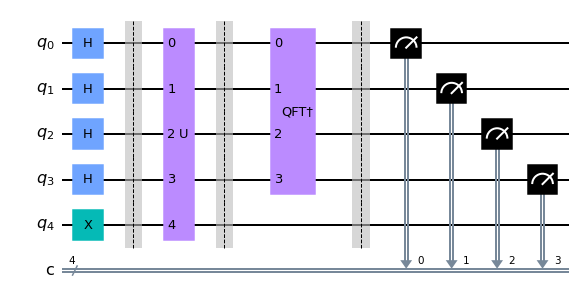

In [24]:
def qpe(qc,t,l,theta):
    
    qtot=t+l
    #qc = QuantumCircuit(qtot,t)
    
    for q in range(t):
        qc.h(q)
    
    #implementation of the eigenstate |1>
    qc.x(qtot-1)
    
    qc.barrier()
    
    angle = 2*np.pi*theta #qpe works with 2pi*theta
    qc = apply_U(qc,angle,t,qtot)
    qc.barrier()
    qc = inv_qft(qc,t)
    qc.barrier()
    
    return qc


t = 4 #precision
l = 1 #qbits necessary to implement the eigenstate
qtot = t+l #total qbits
theta = 1/3

qc = QuantumCircuit(qtot,t)
qc = qpe(qc,t,l,theta)
for q in range(t):
    qc.measure(q,q)
    
qc.draw(output='mpl')


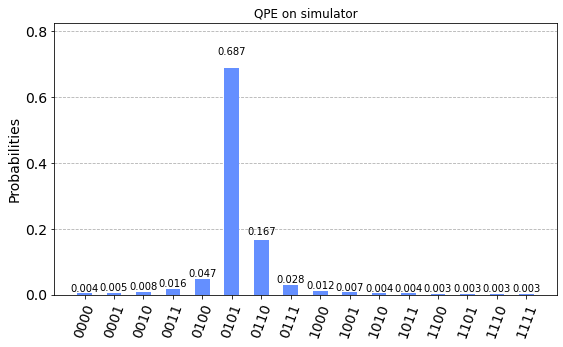

In [20]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 20000
t_qpe = transpile(qc, aer_sim)
results = aer_sim.run(t_qpe,shots=shots).result()
answer = results.get_counts()

plot_histogram(answer,figsize=(9,5), title='QPE on simulator')

In [32]:
small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                    and not x.configuration().simulator
                                    and x.status().operational==True)

backend = least_busy(small_devices)

print(backend.name())
#backend

In [ ]:
qc_trans = transpile(qc,backend,optimization_level=3)
shots = 20000
job = backend.run(qc_trans,shots=shots)
print(job.job_id())
job_monitor(job)

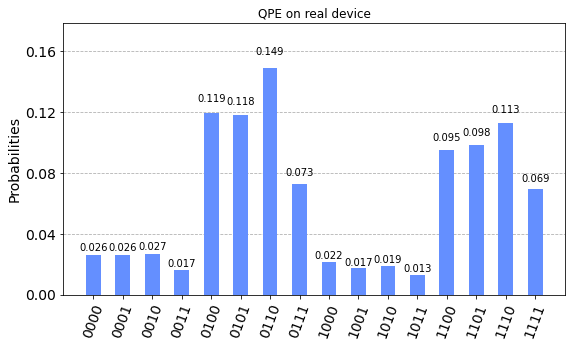

In [31]:
results = job.result()
counts = results.get_counts()
plot_histogram(counts,figsize=(9,5),title='QPE on real device')

In [ ]:
'''
the only purpose of this cell is to print a circuit were the controlled phases are drawn explicitly
'''
t = 4 #precision
l = 1 #qbits necessary to implement the eigenstate
qtot = t+l #total qbits
theta = 1/3
qc = QuantumCircuit(qtot,t)

for q in range(t):
        qc.h(q)
    
#implementation of the eigenstate |1>
qc.x(qtot-1)
qc.barrier()
    
angle = 2*np.pi*theta #qpe works with 2pi*theta
for k in range(t):
    qc.cp(2/3*np.pi*(2**k),qtot-1,k)
qc.barrier()
qc = inv_qft(qc,t)
qc.barrier()

for q in range(t):
    qc.measure(q,q)
    
qc.draw('mpl',filename='QPE.png')